In [53]:
import os
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers

## DATASET: Loading and Preprocessing

The dataset comes in different formats. These two classes are designed to read annotation files where each line points to an image file and its corresponding label. It supports different annotation formats, like in MJSynth and ICDAR datasets.

In [54]:
img_shape1=(32, 128, 3)  # 32 x 128 pixels, RGC images
# It is crucial that all input to the CRNN has consistent shape and size

In [55]:
try:
    AUTOTUNE = tf.data.AUTOTUNE
except AttributeError:
    # tf < 2.4.0
    AUTOTUNE = tf.data.experimental.AUTOTUNE # automatically tune various parameters dynamically at runtime


# This reads the text file where each line represents an image ??
class Dataset(tf.data.TextLineDataset):
    def __init__(self, filename, **kwargs):
        self.dirname = os.path.dirname(filename)
        super().__init__(filename, **kwargs)

    def parse_func(self, line):
        raise NotImplementedError
        
        
    # Reads a line from the file, splits it into image path and label
    def parse_line(self, line):
        line = tf.strings.strip(line)
        img_relative_path, label = self.parse_func(line)
        img_path = tf.strings.join([self.dirname, os.sep, img_relative_path])
        #img_path = tf.strings.join(['/kaggle/input/mjsynth/mnt/ramdisk/max/90kDICT32px', os.sep, img_relative_path])  ## CHANGED
        return img_path, label

"""
class SimpleDataset(Dataset):
    def parse_func(self, line):
        splited_line = tf.strings.split(line)
        img_relative_path, label = splited_line[0], splited_line[1]
        return img_relative_path, label
"""

class MJSynthDataset(Dataset):
    def parse_func(self, line):
        splited_line = tf.strings.split(line)
        img_relative_path = splited_line[0]
        label = tf.strings.split(img_relative_path, sep="_")[1]
        return img_relative_path, label


class ICDARDataset(Dataset):
    def parse_func(self, line):
        splited_line = tf.strings.split(line, sep=",")
        img_relative_path, label = splited_line[0], splited_line[1]
        label = tf.strings.strip(label)
        label = tf.strings.regex_replace(label, r'"', "")
        return img_relative_path, label


class DatasetBuilder:
    def __init__(
        self,
        table_path,
        img_shape=img_shape1,
        max_img_width=300,
        ignore_case=False,
    ):
       # Static HashTable to lookup the labels 
        # map unknown label to 0
        self.table = tf.lookup.StaticHashTable(
            tf.lookup.TextFileInitializer(
                table_path,
                tf.string,
                tf.lookup.TextFileIndex.WHOLE_LINE,  # either a whole line is used as a key
                tf.int64,
                tf.lookup.TextFileIndex.LINE_NUMBER, # or a line number
            ),
            0,
        )
        self.img_shape = img_shape
        self.ignore_case = ignore_case
        if img_shape[1] is None:
            self.max_img_width = max_img_width
            self.preserve_aspect_ratio = True
        else:
            self.preserve_aspect_ratio = False

    # the number of unique classes/labels.        
    @property
    def num_classes(self):
        return self.table.size()
    
    
    #  Determines the format of the annotation file according to the appropriate dataset
    def _parse_annotation(self, path):
        with open(path) as f:
            line = f.readline().strip()
        if re.fullmatch(r".*/*\d+_.+_(\d+)\.\w+ \1", line):
            return MJSynthDataset(path)
        elif re.fullmatch(r'.*/*word_\d\.\w+, ".+"', line):
            return ICDARDataset(path)
        elif re.fullmatch(r".+\.\w+ .+", line):
            return SimpleDataset(path)
        else:
            raise ValueError("Unsupported annotation format")
    # Concatenate 
    def _concatenate_ds(self, ann_paths):
        datasets = [self._parse_annotation(path) for path in ann_paths]
        concatenated_ds = datasets[0].map(datasets[0].parse_line)
        for ds in datasets[1:]:
            ds = ds.map(ds.parse_line)
            concatenated_ds = concatenated_ds.concatenate(ds)
        return concatenated_ds

    def _decode_img(self, filename, label):
        img = tf.io.read_file(filename)
        img = tf.io.decode_jpeg(img, channels=self.img_shape[-1])
        
        img = tf.image.resize_with_pad(img, self.img_shape[0], self.img_shape[1]) / 255.0 # normalized image
        
        return img, label

    # exclude images wider than a maximum width
    def _filter_img(self, img, label):
        img_shape = tf.shape(img)
        return img_shape[1] < self.max_img_width

    #  Converts text labels into numerical tokens using a lookup table
    def _tokenize(self, imgs, labels):
        chars = tf.strings.unicode_split(labels, "UTF-8")
        tokens = tf.ragged.map_flat_values(self.table.lookup, chars)
        # TODO(hym) Waiting for official support to use RaggedTensor in keras
        tokens = tokens.to_sparse()
        return imgs, tokens

    # Constructs the dataset by concatenating, decoding, filtering, batching, and tokenizing the data. I
    def __call__(self, ann_paths, batch_size, is_training):
        ds = self._concatenate_ds(ann_paths)
        if self.ignore_case:
            ds = ds.map(lambda x, y: (x, tf.strings.lower(y)))
        if is_training:
            ds = ds.shuffle(buffer_size=10000)
        ds = ds.map(self._decode_img, AUTOTUNE)
        if self.preserve_aspect_ratio and batch_size != 1:
            ds = ds.filter(self._filter_img)
            ds = ds.padded_batch(batch_size, drop_remainder=is_training)
        else:
            ds = ds.batch(batch_size, drop_remainder=is_training)
        ds = ds.map(self._tokenize, AUTOTUNE)
        ds = ds.prefetch(AUTOTUNE)
        return ds

## Decoders:
- GreedyDecoder
- BeamSearchDecoder

In [56]:

class CTCDecoder(keras.layers.Layer): # Base Class
    def __init__(self, table_path, **kwargs):
        super().__init__(**kwargs)
        self.table = tf.lookup.StaticHashTable(
            tf.lookup.TextFileInitializer(
                table_path,
                tf.int64,
                tf.lookup.TextFileIndex.LINE_NUMBER,
                tf.string,
                tf.lookup.TextFileIndex.WHOLE_LINE,
            ),
            "",
        )

    def detokenize(self, x):
        x = tf.RaggedTensor.from_sparse(x)
        x = tf.ragged.map_flat_values(self.table.lookup, x)
        strings = tf.strings.reduce_join(x, axis=1)
        return strings


class CTCGreedyDecoder(CTCDecoder):
    def __init__(self, table_path, merge_repeated=True, **kwargs):
        super().__init__(table_path, **kwargs)
        self.merge_repeated = merge_repeated

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        sequence_length = tf.fill([input_shape[0]], input_shape[1])
        decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(
            tf.transpose(inputs, perm=[1, 0, 2]),
            sequence_length,
            self.merge_repeated,
        )
        strings = self.detokenize(decoded[0])
        labels = tf.cast(decoded[0], tf.int32)
        loss = tf.nn.ctc_loss( 
            labels=labels,
            logits=inputs,
            label_length=None,
            logit_length=sequence_length,
            logits_time_major=False,
            blank_index=-1,
        )
        probability = tf.math.exp(-loss)  # calculates a probablity score based on the CTC loss
        return strings, probability

    
# Considers multiple paths for decoding => can get better accuracy but slower
class CTCBeamSearchDecoder(CTCDecoder):
    def __init__(self, table_path, beam_width=100, top_paths=1, **kwargs):
        super().__init__(table_path, **kwargs)
        self.beam_width = beam_width
        self.top_paths = top_paths

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        decoded, log_probability = tf.nn.ctc_beam_search_decoder(
            tf.transpose(inputs, perm=[1, 0, 2]),
            tf.fill([input_shape[0]], input_shape[1]),
            self.beam_width,
            self.top_paths,
        )
        strings = []
        for i in range(self.top_paths):
            strings.append(self.detokenize(decoded[i]))
        strings = tf.concat(strings, 1)
        probability = tf.math.exp(log_probability)  # calculates a probablity score based 
        return strings, probability                 # on the log probabilities returned by the beam search decoder.


### Losses: CTC loss
Connectionist temporal classification

In [58]:
# import tensorflow as tf
# from tensorflow import keras


class CTCLoss(keras.losses.Loss):
    """A class that wraps the function of tf.nn.ctc_loss.

    Attributes:
        logits_time_major: If False (default) , shape is [batch, time, logits],
            If True, logits is shaped [time, batch, logits].
        blank_index: Set the class index to use for the blank label. default is
            -1 (num_classes - 1).
    """

    def __init__(
        self, logits_time_major=False, blank_index=-1, name="ctc_loss"
    ):
        super().__init__(name=name)
        self.logits_time_major = logits_time_major
        self.blank_index = blank_index

    def call(self, y_true, y_pred):
        """Computes CTC (Connectionist Temporal Classification) loss. work on
        CPU, because y_true is a SparseTensor.
        """
        y_true = tf.cast(y_true, tf.int32)
        y_pred_shape = tf.shape(y_pred)
        logit_length = tf.fill([y_pred_shape[0]], y_pred_shape[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=None,
            logit_length=logit_length, # pred length
            logits_time_major=self.logits_time_major,
            blank_index=self.blank_index,
        )
        return tf.math.reduce_mean(loss)


### Metrics
- Sequence Accuracy: exact accuracy, measures the percentage of correct sequences.
- Edit Distance: not exact prediction, measures the average number of insertions, deletions, or substitutions required to change predicted sequences into the correct ones.


In [59]:
# import tensorflow as tf
# from tensorflow import keras


class SequenceAccuracy(keras.metrics.Metric):
    def __init__(self, name="sequence_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        def sparse2dense(tensor, shape):
            tensor = tf.sparse.reset_shape(tensor, shape)
            tensor = tf.sparse.to_dense(tensor, default_value=-1)
            tensor = tf.cast(tensor, tf.float32)
            return tensor

        y_true_shape = tf.shape(y_true)
        batch_size = y_true_shape[0]
        y_pred_shape = tf.shape(y_pred)
        max_width = tf.math.maximum(y_true_shape[1], y_pred_shape[1])
        logit_length = tf.fill([batch_size], y_pred_shape[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(y_pred, perm=[1, 0, 2]),
            sequence_length=logit_length,
        )
        y_true = sparse2dense(y_true, [batch_size, max_width])
        y_pred = sparse2dense(decoded[0], [batch_size, max_width])
        num_errors = tf.math.reduce_any(
            tf.math.not_equal(y_true, y_pred), axis=1
        )
        num_errors = tf.cast(num_errors, tf.float32)
        num_errors = tf.math.reduce_sum(num_errors)
        batch_size = tf.cast(batch_size, tf.float32)
        self.total.assign_add(batch_size)
        self.count.assign_add(batch_size - num_errors)

    def result(self):
        return self.count / self.total

    def reset_states(self):
        self.count.assign(0)
        self.total.assign(0)


class EditDistance(keras.metrics.Metric):
    def __init__(self, name="edit_distance", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.sum_distance = self.add_weight(
            name="sum_distance", initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_shape = tf.shape(y_pred)
        batch_size = y_pred_shape[0]
        logit_length = tf.fill([batch_size], y_pred_shape[1])
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(y_pred, perm=[1, 0, 2]),
            sequence_length=logit_length,
        )
        sum_distance = tf.math.reduce_sum(tf.edit_distance(decoded[0], y_true))
        batch_size = tf.cast(batch_size, tf.float32)
        self.sum_distance.assign_add(sum_distance)
        self.total.assign_add(batch_size)

    def result(self):
        return self.sum_distance / self.total

    def reset_states(self):
        self.sum_distance.assign(0)
        self.total.assign(0)

## Model
**Convolutional Recurrent Neural Network:** combining VGG-style convolutional layers for feature extraction and **bidirectional LSTM** layers for **sequence modeling**.The pre and post processing steps are left optional, for a specified number of output classes.
>VGG stands for Visual Graphics Group, make sure that the architecture is uniform

In [60]:
# from tensorflow import keras
# from tensorflow.keras import layers


def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = layers.Conv2D(64, 3, padding="same", activation="relu", name="conv1")(x)
    x = layers.MaxPool2D(pool_size=2, padding="same", name="pool1")(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu", name="conv2")(x)
    x = layers.MaxPool2D(pool_size=2, padding="same", name="pool2")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False, name="conv3")(x)
    x = layers.BatchNormalization(name="bn3")(x)
    x = layers.Activation("relu", name="relu3")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu", name="conv4")(x)
    x = layers.MaxPool2D(pool_size=2, strides=(2, 1), padding="same", name="pool4")(x)

    x = layers.Conv2D(512, 3, padding="same", use_bias=False, name="conv5")(x)
    x = layers.BatchNormalization(name="bn5")(x)
    x = layers.Activation("relu", name="relu5")(x)
    x = layers.Conv2D(512, 3, padding="same", activation="relu", name="conv6")(x)
    x = layers.MaxPool2D(pool_size=2, strides=(2, 1), padding="same", name="pool6")(x)

    x = layers.Conv2D(512, 2, use_bias=False, name="conv7")(x)
    x = layers.BatchNormalization(name="bn7")(x)
    x = layers.Activation("relu", name="relu7")(x)

    x = layers.Reshape((-1, 512), name="reshape7")(x)
    return x


def build_model(
    num_classes,
    weight=None,
    preprocess=None,
    postprocess=None,
    img_shape=img_shape1,
    model_name="crnn",
):
    x = img_input = keras.Input(shape=img_shape)
    if preprocess is not None:
        x = preprocess(x)

    x = vgg_style(x)
    x = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True), name="bi_lstm1")(x)
    x = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True), name="bi_lstm2")(x)
    x = layers.Dense(units=num_classes, name="logits")(x)

    if postprocess is not None:
        x = postprocess(x)

    model = keras.Model(inputs=img_input, outputs=x, name=model_name)
    if weight is not None:
        model.load_weights(weight, by_name=True, skip_mismatch=True)
    return model


**Assembling stuff**

In [62]:
# base="./mjsynth/mnt/ramdisk/max/90kDICT32px"
# train_path=base+"/small_train.txt"
# test_path=base+"/small_test.txt"
# val_path=base+"/small_val.txt"

train_path="/kaggle/input/mjsynth-clean-annotation-files/train.txt"
test_path="/kaggle/input/mjsynth-clean-annotation-files/test.txt"
val_path="/kaggle/input/mjsynth-clean-annotation-files/val.txt"

table_path="/kaggle/input/table/example/table.txt"
# img_shape_config=[32, None, 3]
img_shape_config=img_shape1
data = {
    "dataset_builder": {
        "table_path": table_path,
        "img_shape": img_shape_config,
        "max_img_width": 300,
        "ignore_case": True
    },
    "train": {
        "dataset_builder": {
            "table_path": table_path,
            "img_shape": img_shape_config,
            "max_img_width": 300,
            "ignore_case": True
        },
        "train_ann_paths":  [
            train_path,
            val_path
        ],
        "val_ann_paths": [test_path],
        "batch_size_per_replica": 128,
        "epochs": 20,
        "lr_schedule": {
            "initial_learning_rate": 0.0001,
            "decay_steps": 600000,
            "alpha": 0.01
        },
        "tensorboard": {
            "histogram_freq": 1,
            "profile_batch": 0
        }
    },
    "eval": {
        "dataset_builder": {
            "table_path": table_path,
            "img_shape": img_shape_config,
            "max_img_width": 300,
            "ignore_case": True
        },
        "ann_paths": ["/kaggle/input/icdar2013/Challenge2_Test_Task3_Images/Challenge2_Test_Task3_GT.txt"],
        "batch_size": 128
    }
}

# Printing the Python dictionary
import pprint
pprint.pprint(data)

config=data["train"]

{'dataset_builder': {'ignore_case': True,
                     'img_shape': (32, 128, 3),
                     'max_img_width': 300,
                     'table_path': '/kaggle/input/table/example/table.txt'},
 'eval': {'ann_paths': ['/kaggle/input/icdar2013/Challenge2_Test_Task3_Images/Challenge2_Test_Task3_GT.txt'],
          'batch_size': 128,
          'dataset_builder': {'ignore_case': True,
                              'img_shape': (32, 128, 3),
                              'max_img_width': 300,
                              'table_path': '/kaggle/input/table/example/table.txt'}},
 'train': {'batch_size_per_replica': 128,
           'dataset_builder': {'ignore_case': True,
                               'img_shape': (32, 128, 3),
                               'max_img_width': 300,
                               'table_path': '/kaggle/input/table/example/table.txt'},
           'epochs': 20,
           'lr_schedule': {'alpha': 0.01,
                           'decay_steps': 600

### Train.py

In [63]:
# make sure if it is = 2
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
gpus

Num GPUs Available:  2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Do not run this. load the weights instead, the ".h5" file

In [64]:
import argparse
import pprint
import shutil
from pathlib import Path

import tensorflow as tf
import yaml
from tensorflow import keras

# from dataset_factory import DatasetBuilder
# from losses import CTCLoss
# from metrics import SequenceAccuracy
# from models import build_model

config=data["train"]

output_directory = "./output"

# Ensure the directory exists; create it if it doesn't
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
import pathlib

directory_path = pathlib.Path('./output')

# Check if the directory is not empty
# if any(directory_path.iterdir()):
#     raise ValueError(f"The directory '{directory_path}' is not empty.")

#
# ==============================================================
#

import os
import json
# Specify the directory where you want to create the file
output_directory = "./output"

# Ensure the directory exists; create it if it doesn't
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# File path to save the JSON data
file_path = output_directory+"data.json"

# Write the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file, indent=4)

print(f"Dictionary has been written to '{file_path}'.")

#
# ==============================================================
#

strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
# strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
batch_size = config["batch_size_per_replica"] * strategy.num_replicas_in_sync

dataset_builder = DatasetBuilder(**config["dataset_builder"])
train_ds = dataset_builder(config["train_ann_paths"], batch_size, True)
val_ds = dataset_builder(config["val_ann_paths"], batch_size, False)

with strategy.scope():
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        **config["lr_schedule"]
    )
    model = build_model(
        dataset_builder.num_classes,
        weight=config.get("weight"),
        img_shape=config["dataset_builder"]["img_shape"],
    )
    model.compile(
        optimizer=keras.optimizers.Adam(lr_schedule),
        loss=CTCLoss(),
        metrics=[SequenceAccuracy()],
    )

model.summary()
import time
model_prefix = "{epoch}_{val_loss:.4f}_{val_sequence_accuracy:.4f}"
model_path = f"{output_directory}/{model_prefix}.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True,save_freq='epoch'),
#     keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True,save_freq='epoch'),
    keras.callbacks.TensorBoard(
        log_dir=f"{output_directory}/logs", **config["tensorboard"]
    ),
]


Dictionary has been written to './outputdata.json'.
Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 128, 3)]      0         
                                                                 
 conv1 (Conv2D)              (None, 32, 128, 64)       1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 64, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 64, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 32, 128)        0         
                                                                 
 conv3 (Conv2D)              (None, 8, 32, 256)        294912    
                                                                 
 bn3 (Batc

In [68]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
print(strategy)

# Loading model and conitnung to train
> before we trained for only one epoch, that takes around 4h. If it's possible, you can train again for x epochs (small x). make sure to save the new weights.

In [69]:
# load Model and continue training
config=data["train"]
# strategy = tf.distribute.MirroredStrategy()
# strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
# strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
batch_size = config["batch_size_per_replica"] * strategy.num_replicas_in_sync

dataset_builder = DatasetBuilder(**config["dataset_builder"])
train_ds = dataset_builder(config["train_ann_paths"], batch_size, True)
val_ds = dataset_builder(config["val_ann_paths"], batch_size, False)

with strategy.scope():
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        **config["lr_schedule"]
    )
    model = build_model(
        dataset_builder.num_classes,
        weight=config.get("weight"),
        img_shape=config["dataset_builder"]["img_shape"],
    )
    model.compile(
        optimizer=keras.optimizers.Adam(lr_schedule),
        loss=CTCLoss(),
        metrics=[SequenceAccuracy()],
    )

# model = tf.keras.models.load_model('./output/20_18.5377_0.0000.h5')

model.load_weights('/kaggle/input/d/antoinemnr/training/one_epoch.h5')
output_directory = "./output_2"
model.summary()
import time
model_prefix = "{epoch}_{val_loss:.4f}_{val_sequence_accuracy:.4f}"
model_path = f"{output_directory}/{model_prefix}.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True, period=25),
    keras.callbacks.TensorBoard(
        log_dir=f"{output_directory}/logs", **config["tensorboard"]
    ),
]
#model.fit(
#     train_ds,
#     epochs=100,
#    callbacks=callbacks,
#     validation_data=val_ds,
#)

Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 128, 3)]      0         
                                                                 
 conv1 (Conv2D)              (None, 32, 128, 64)       1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 64, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 64, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 32, 128)        0         
                                                                 
 conv3 (Conv2D)              (None, 8, 32, 256)        294912    
                                                                 
 bn3 (BatchNormalization)    (None, 8, 32, 256)        1024   

In [70]:
# to see if the Distributed computation is working
print("Batch size per replica:", config["batch_size_per_replica"])
print("Number of replicas in sync:", strategy.num_replicas_in_sync)
print("Distributed Strategy: ", strategy)

Batch size per replica: 128
Number of replicas in sync: 2
Distributed Strategy:  <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7ec87ee61b40>


In [71]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir='./logs', profile_batch='500,520')
]


**Minor Test**

## Eval:


In [72]:
train_path="/kaggle/input/mjsynth-clean-annotation-files/train.txt"
test_path="/kaggle/input/mjsynth-clean-annotation-files/test.txt"
val_path="/kaggle/input/mjsynth-clean-annotation-files/val.txt"

table_path="/kaggle/input/table/example/table.txt"
# img_shape_config=[32, None, 3]
img_shape_config=img_shape1
data = {
    "dataset_builder": {
        "table_path": table_path,
        "img_shape": img_shape_config,
        "max_img_width": 300,
        "ignore_case": True
    },
    "train": {
        "dataset_builder": {
            "table_path": table_path,
            "img_shape": img_shape_config,
            "max_img_width": 300,
            "ignore_case": True
        },
        "train_ann_paths":  [
            train_path,
            val_path
        ],
        "val_ann_paths": [test_path],
        "batch_size_per_replica": 128,
        "epochs": 20,
        "lr_schedule": {
            "initial_learning_rate": 0.0001,
            "decay_steps": 600000,
            "alpha": 0.01
        },
        "tensorboard": {
            "histogram_freq": 1,
            "profile_batch": 0
        }
    },
    "eval": {
        "dataset_builder": {
            "table_path": table_path,
            "img_shape": img_shape_config,
            "max_img_width": 300,
            "ignore_case": True
        },
        "ann_paths": ["/kaggle/input/icdar2013/Challenge2_Test_Task3_Images/Challenge2_Test_Task3_GT.txt"],
        "batch_size": 128
    }
}
print(data)


{'dataset_builder': {'table_path': '/kaggle/input/table/example/table.txt', 'img_shape': (32, 128, 3), 'max_img_width': 300, 'ignore_case': True}, 'train': {'dataset_builder': {'table_path': '/kaggle/input/table/example/table.txt', 'img_shape': (32, 128, 3), 'max_img_width': 300, 'ignore_case': True}, 'train_ann_paths': ['/kaggle/input/mjsynth-clean-annotation-files/train.txt', '/kaggle/input/mjsynth-clean-annotation-files/val.txt'], 'val_ann_paths': ['/kaggle/input/mjsynth-clean-annotation-files/test.txt'], 'batch_size_per_replica': 128, 'epochs': 20, 'lr_schedule': {'initial_learning_rate': 0.0001, 'decay_steps': 600000, 'alpha': 0.01}, 'tensorboard': {'histogram_freq': 1, 'profile_batch': 0}}, 'eval': {'dataset_builder': {'table_path': '/kaggle/input/table/example/table.txt', 'img_shape': (32, 128, 3), 'max_img_width': 300, 'ignore_case': True}, 'ann_paths': ['/kaggle/input/icdar2013/Challenge2_Test_Task3_Images/Challenge2_Test_Task3_GT.txt'], 'batch_size': 128}}


This **evaluates** using the icdar13 files of images and annotations

In [73]:
config=data["eval"]
dataset_builder = DatasetBuilder(**config["dataset_builder"])
ds = dataset_builder(config["ann_paths"], config["batch_size"], False)
for images, labels in ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
model = build_model(
     dataset_builder.num_classes,
     weight="/kaggle/input/d/antoinemnr/training/one_epoch.h5",
     img_shape=config["dataset_builder"]["img_shape"],
 )
model.compile(loss=CTCLoss(), metrics=[SequenceAccuracy(), EditDistance()])
model.evaluate(ds)

Image batch shape: (128, 32, 128, 3)
Label batch shape: (128, 19)
9/9 [==============================] - 7s 233ms/step - loss: 7.1503 - sequence_accuracy: 0.4977 - edit_distance: 0.3351


[7.150275707244873, 0.49771690368652344, 0.3351057171821594]

In [74]:
import numpy as np
from PIL import Image

# Load and preprocess the image
image_path = '/kaggle/input/table/example/images/2_Reimbursing_64165.jpg'
image = Image.open(image_path).convert('RGB')
image = image.resize((128, 32))  # Resize to the input size expected by your model
image = np.array(image)
image = image / 255.0  # Normalize pixel values if required
valid_img = np.expand_dims(image, axis=0)  # Add batch dimension

# Load the model weights
model.load_weights('//kaggle/input/d/antoinemnr/training/one_epoch.h5')
# # predict outputs on validation images

#prediction = model.predict(valid_img)
y_pred = model.predict(valid_img)   


# Instantiate the decoder - replace 'your_table_path.txt' with the actual path to your character table
decoder = CTCGreedyDecoder(table_path='/kaggle/input/table/example/table.txt')

# Decode the predictions
decoded_strings, probabilities = decoder.call(y_pred)

# Process the output
for string, probability in zip(decoded_strings.numpy(), probabilities.numpy()):
    print("Predicted text:", string.decode('utf-8'))
    print("Probability:", probability)

1/1 [==============================] - 1s 1s/step
Predicted text: reimbursing
Probability: 0.5314354


In [99]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

blur = A.Blur(blur_limit=5, p=1.0)
rotate = A.Rotate(limit=90, interpolation=1, border_mode=4, value=None, mask_value=None, p=1.0)
shift_scale_rotaet = A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, border_mode=4, value=None, mask_value=None, p=1.0)
optical_distortion = A.OpticalDistortion(distort_limit=1, shift_limit=0.05, interpolation=1, border_mode=4, p=1.0)
grid_distortion = A.GridDistortion(num_steps=6, distort_limit=0.5, interpolation=1, border_mode=4, p=1.0)
elastic= A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=1.0)
coarse_dropout = A.CoarseDropout(max_holes=16, max_height=32, max_width=32, min_holes=1, min_height=8, min_width=8, fill_value=0, p=1.0)

In [173]:
def show_img(img, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

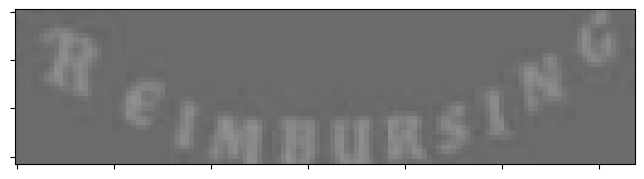

In [174]:
image = cv2.imread('/kaggle/input/table/example/images/2_Reimbursing_64165.jpg')  # cute dog #1
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 32))
show_img(image)

In [147]:
links = pd.read_csv("/kaggle/input/iii5vk/links.csv")
links = links.replace("'", "", regex=True)
links['GroundTruth'] = links['GroundTruth'].str.lower()

In [148]:
links.head()

,ImgName,GroundTruth
0,test/1002_1.png,private
1,test/1002_2.png,parking
2,test/1009_1.png,salutes
3,test/100_1.png,dolce
4,test/100_2.png,gabbana


In [157]:
df_100 = links.sample(100)

In [172]:
from sklearn.metrics import accuracy_score
import editdistance

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def calculate_edit_distance(y_true, y_pred):
    total_distance = 0
    for true, pred in zip(y_true, y_pred):
        total_distance += editdistance.eval(true, pred)
    return total_distance / len(y_true)

# No transformation

In [162]:
predictions = []
ground_truth = []

for index, row in df_100.iterrows():
    image_path = "/kaggle/input/iii5vk/test/" + row['ImgName']
    image = cv2.imread(image_path)  # cute dog #1
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 32))
    image = np.array(image)
    image = image / 255.0  # Normalize pixel values if required
    valid_img = np.expand_dims(image, axis=0)  # Add batch dimension
    

    y_pred = model.predict(valid_img, verbose=0)   

    decoder = CTCGreedyDecoder(table_path='/kaggle/input/table/example/table.txt')

    # Decode the predictions
    decoded_strings, probabilities = decoder.call(y_pred)

    predictions.append(decoded_strings.numpy()[0].decode('utf-8'))
    ground_truth.append(row['GroundTruth'])

print(f"Sequence Accuracy: {calculate_accuracy(predictions, ground_truth)}")
print(f"Edit Distance: {calculate_edit_distance(predictions, ground_truth)}")

Sequence Accuracy: 0.43
Edit Distance: 1.62


In [163]:
def apply_transformation_and_predict(df, transform_func):
    predictions = []
    ground_truth = []

    for index, row in df.iterrows():
        image_path = "/kaggle/input/iii5vk/test/" + row['ImgName']
        image = cv2.imread(image_path)  # cute dog #1
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 32))
        
        new_image = transform_func(image = image)['image']
        image = np.array(new_image)
        image = image / 255.0  # Normalize pixel values if required
        valid_img = np.expand_dims(image, axis=0)  # Add batch dimension

        y_pred = model.predict(valid_img, verbose=0)   

        decoder = CTCGreedyDecoder(table_path='/kaggle/input/table/example/table.txt')

        # Decode the predictions
        decoded_strings, probabilities = decoder.call(y_pred)
        
        predictions.append(decoded_strings.numpy()[0].decode('utf-8'))
        ground_truth.append(row['GroundTruth'])
        
    print(f"Sequence Accuracy: {calculate_accuracy(predictions, ground_truth)}")
    print(f"Edit Distance: {calculate_edit_distance(predictions, ground_truth)}")

In [164]:
apply_transformation_and_predict(df_100, blur)

Sequence Accuracy: 0.33
Edit Distance: 2.14


In [165]:
apply_transformation_and_predict(df_100, rotate)

Sequence Accuracy: 0.04
Edit Distance: 4.11


In [166]:
apply_transformation_and_predict(df_100, shift_scale_rotaet)

Sequence Accuracy: 0.1
Edit Distance: 3.2


In [167]:
apply_transformation_and_predict(df_100, optical_distortion)

Sequence Accuracy: 0.18
Edit Distance: 2.26


In [169]:
apply_transformation_and_predict(df_100, grid_distortion)

Sequence Accuracy: 0.12
Edit Distance: 2.32


In [170]:
apply_transformation_and_predict(df_100, elastic)

Sequence Accuracy: 0.0
Edit Distance: 5.09


In [171]:
apply_transformation_and_predict(df_100, coarse_dropout)

Sequence Accuracy: 0.02
Edit Distance: 3.8


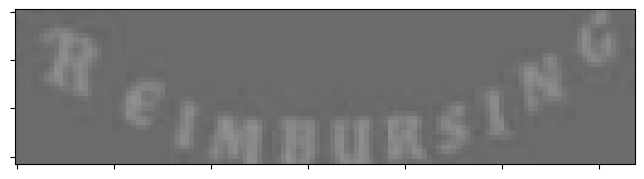

In [100]:
image = cv2.imread('/kaggle/input/table/example/images/2_Reimbursing_64165.jpg')  # cute dog #1
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 32))
show_img(image)

# Blur

In [116]:
new_image = blur(image = image)['image']
image = np.array(new_image)
image = image / 255.0  # Normalize pixel values if required
valid_img = np.expand_dims(image, axis=0)  # Add batch dimension

y_pred = model.predict(valid_img)   

decoder = CTCGreedyDecoder(table_path='/kaggle/input/table/example/table.txt')

# Decode the predictions
decoded_strings, probabilities = decoder.call(y_pred)

# Process the output
for string, probability in zip(decoded_strings.numpy(), probabilities.numpy()):
    print("Predicted text:", string.decode('utf-8'))
    print("Probability:", probability)

1/1 [==============================] - 0s 29ms/step
Predicted text: reneeroins
Probability: 1.8614128e-06


In [126]:
from sklearn.metrics import accuracy_score
import editdistance

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def calculate_edit_distance(y_true, y_pred):
    total_distance = 0
    for true, pred in zip(y_true, y_pred):
        total_distance += editdistance.eval(true, pred)
    return total_distance / len(y_true)